# 3D Keypoint Social Interaction Analysis

**Author:** Mir Qi  
**Date:** October 2024  
**Purpose:** Analyze 3D keypoint tracking data from s-DANNCE for multi-animal social behavior experiments. 

## Overview

This notebook demonstrates analysis of 3D pose tracking data merged/aligned with calcium imaging (miniscope) recordings. The pipeline includes:

1. **Data Loading**: Merge s-DANNCE predictions with miniscope and COM data
2. **Distance Analysis**: Compute inter-animal distances and proximity events
3. **Motion Analysis**: Calculate velocities, speeds, and approach behaviors
4. **Visualization**: Plot skeletons, trajectories, and interaction heatmaps
5. **Event Detection**: Identify social interaction incidents and approach sequences

---

## Setup & Imports

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Add project root to path, if you installed the project no longe need this!
sys.path.append(os.path.abspath('../'))

# Import data loading utilities
from utlis.sync_utlis.general_loader import load_flat_with_frame_map, merge_pred_with_miniscope
from utlis.sync_utlis.general_loader_viz import plot_two_coms_from_pred_df

# Import our analysis functions
from utlis.present_vis.keypoint_3d_analysis import (
    compute_com_distance,
    compute_motion_direction,
    find_approach_success,
    get_proximity_rows_by_com,
    point_distance,
    snout_to,
    plot_skeleton_frames,
    plot_incidents_3d_grid,
    plot_ca_heatmap_and_distance,
    plot_incident_windows_newset,
    visualize_frames_allcams,
    KP, MOUSE22_EDGES
)

# Display settings
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 120)

print("✓ Imports complete")


✓ Imports complete


---
## 1. Load & Merge Data

Load s-DANNCE predictions and merge with miniscope calcium imaging data.

In [32]:
from utlis.sync_utlis.loader_new_struct import merge_all_data_new_structure

rec_path = "/data/big_rim/uploade_ssh_mir_dataset/oct3v1_mini/social/20241031_VC4+UNK1_S1"

merged, beh, mini, pose_arr, ca_arr, dff_arr = merge_all_data_new_structure(rec_path)



print("Merged DataFrame shape:", merged.shape)

print("Behavior DataFrame shape:", beh.shape)

print("Miniscope DataFrame shape:", mini.shape)

print("Pose array shape:", pose_arr.shape)

print("Calcium array shape:", ca_arr.shape)

print("dF/F array shape:", dff_arr.shape)

Merged DataFrame shape: (8954, 156)
Behavior DataFrame shape: (8954, 61)
Miniscope DataFrame shape: (8954, 95)
Pose array shape: (8954, 2, 3, 9)
Calcium array shape: (8954, 47)
dF/F array shape: (8954, 47)


In [33]:
# Display data structure
print("\nColumn categories:")
com_cols = [c for c in merged.columns if 'com' in c]
kp_cols = [c for c in merged.columns if 'kp' in c and '_a1' in c][:10]
ca_cols = [c for c in merged.columns if 'dF_F' in c][:5]

print(f"  COM columns: {len(com_cols)} (e.g., {com_cols[:3]})")
print(f"  Keypoint columns: {len([c for c in merged.columns if 'kp' in c])} (e.g., {kp_cols[:3]})")
print(f"  Calcium imaging: {len([c for c in merged.columns if 'dF_F' in c])} ROIs (e.g., {ca_cols[:3]})")

merged.head()


Column categories:
  COM columns: 6 (e.g., ['com1_x', 'com2_x', 'com1_y'])
  Keypoint columns: 54 (e.g., ['kp1_x_a1', 'kp2_x_a1', 'kp3_x_a1'])
  Calcium imaging: 47 ROIs (e.g., ['dF_F_roi0', 'dF_F_roi1', 'dF_F_roi2'])


,com1_x,com2_x,com1_y,com2_y,com1_z,com2_z,kp1_x_a1,kp2_x_a1,kp3_x_a1,kp4_x_a1,...,dF_F_roi38,dF_F_roi39,dF_F_roi40,dF_F_roi41,dF_F_roi42,dF_F_roi43,dF_F_roi44,dF_F_roi45,dF_F_roi46,miniscope_csv_row
timestamp_ms_mini,,,,,,,,,,,,,,,,,,,,,
-25,708.571832,-3.010296,273.389756,254.433516,16.749412,3.709220,674.986672,705.762593,689.587761,723.649585,...,1.158302,1.409520,2.459621,-0.314477,2.313871,-0.346329,-0.305534,0.554370,-0.315966,0
75,708.451247,-2.550519,273.059690,254.894013,16.740405,3.845094,674.995690,705.650279,689.419092,723.496672,...,0.121381,0.344222,3.187989,0.260308,3.638636,0.117734,-0.109190,0.330735,-0.353665,1
176,708.274950,-1.878333,272.577250,255.567197,16.727269,4.043704,675.008868,705.486075,689.172439,723.273088,...,1.616739,1.216793,2.376566,0.235867,4.208899,0.493787,0.257508,0.848205,-0.184713,2
274,708.086764,-1.161135,272.066197,256.283615,16.714324,4.254444,675.022660,705.310807,688.907253,723.033608,...,-0.047069,1.984129,1.941597,2.426745,4.446576,0.255924,-0.530045,0.743179,-0.263955,3
372,707.886791,-0.402899,271.570756,257.018632,16.713641,4.463023,675.033990,705.124681,688.602379,722.769207,...,-0.168331,0.323331,2.411891,-0.776017,3.656833,0.499899,-0.401815,0.707171,0.091100,4


In [34]:
# Display data structure
print(f"Merged shape: {merged.shape}")
print(f"\nColumns: {list(merged.columns)[:20]}...")
print(f"\nFirst few rows:")
merged.head(3)


Merged shape: (8954, 156)

Columns: ['com1_x', 'com2_x', 'com1_y', 'com2_y', 'com1_z', 'com2_z', 'kp1_x_a1', 'kp2_x_a1', 'kp3_x_a1', 'kp4_x_a1', 'kp5_x_a1', 'kp6_x_a1', 'kp7_x_a1', 'kp8_x_a1', 'kp9_x_a1', 'kp1_y_a1', 'kp2_y_a1', 'kp3_y_a1', 'kp4_y_a1', 'kp5_y_a1']...

First few rows:


,com1_x,com2_x,com1_y,com2_y,com1_z,com2_z,kp1_x_a1,kp2_x_a1,kp3_x_a1,kp4_x_a1,...,dF_F_roi38,dF_F_roi39,dF_F_roi40,dF_F_roi41,dF_F_roi42,dF_F_roi43,dF_F_roi44,dF_F_roi45,dF_F_roi46,miniscope_csv_row
timestamp_ms_mini,,,,,,,,,,,,,,,,,,,,,
-25,708.571832,-3.010296,273.389756,254.433516,16.749412,3.709220,674.986672,705.762593,689.587761,723.649585,...,1.158302,1.409520,2.459621,-0.314477,2.313871,-0.346329,-0.305534,0.554370,-0.315966,0
75,708.451247,-2.550519,273.059690,254.894013,16.740405,3.845094,674.995690,705.650279,689.419092,723.496672,...,0.121381,0.344222,3.187989,0.260308,3.638636,0.117734,-0.109190,0.330735,-0.353665,1
176,708.274950,-1.878333,272.577250,255.567197,16.727269,4.043704,675.008868,705.486075,689.172439,723.273088,...,1.616739,1.216793,2.376566,0.235867,4.208899,0.493787,0.257508,0.848205,-0.184713,2


---
## 2. Compute Inter-Animal Distance

Calculate 3D Euclidean distance between animal centers of mass.


Distance statistics:
  Mean: 363.5 mm
  Min: 2.3 mm
  Max: 1081.2 mm


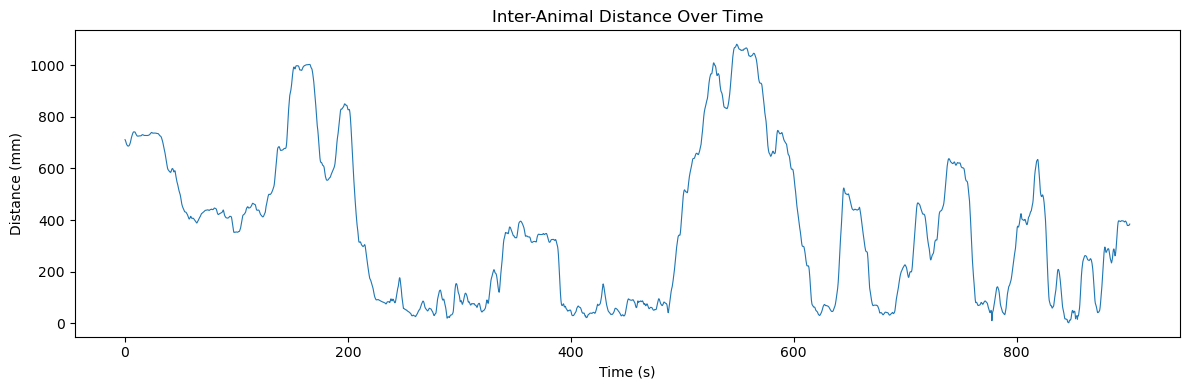

In [35]:
# Compute center-of-mass distance between animals
distance_df = compute_com_distance(
    merged,
    p1="com1",
    p2="com2",
    smooth_window=3,
    dist_smooth_window=3,  # ADD THIS LINE
    return_components=True
)

print(f"Distance statistics:")
print(f"  Mean: {distance_df['dist_mm'].mean():.1f} mm")
print(f"  Min: {distance_df['dist_mm'].min():.1f} mm")
print(f"  Max: {distance_df['dist_mm'].max():.1f} mm")

# Add distance columns to merged DataFrame
merged['dist_mm'] = distance_df['dist_mm']
# Compute dD_dt manually
t_sec = merged.index.to_numpy() / 1000.0  # Convert ms to seconds
merged['dD_dt'] = np.gradient(merged['dist_mm'], t_sec)

# Plot distance over time
plt.figure(figsize=(12, 4))
plt.plot(merged.index / 1000, merged['dist_mm'], lw=0.8)
plt.xlabel('Time (s)')
plt.ylabel('Distance (mm)')
plt.title('Inter-Animal Distance Over Time')
plt.tight_layout()
plt.show()


---
## 3. Motion Analysis

Compute velocities and speeds for both animals.


In [36]:
# Compute motion characteristics for both animals
motion1 = compute_motion_direction(merged, prefix="com1", time_col="timestamp_ms_mini")
motion2 = compute_motion_direction(merged, prefix="com2", time_col="timestamp_ms_mini")

# Add to merged DataFrame
for col in motion1.columns:
    merged[col] = motion1[col]
for col in motion2.columns:
    merged[col] = motion2[col]

print(f"Animal 1 mean speed: {motion1['com1_speed'].mean():.2f} mm/s")
print(f"Animal 2 mean speed: {motion2['com2_speed'].mean():.2f} mm/s")


Animal 1 mean speed: 2.20 mm/s
Animal 2 mean speed: 1.12 mm/s


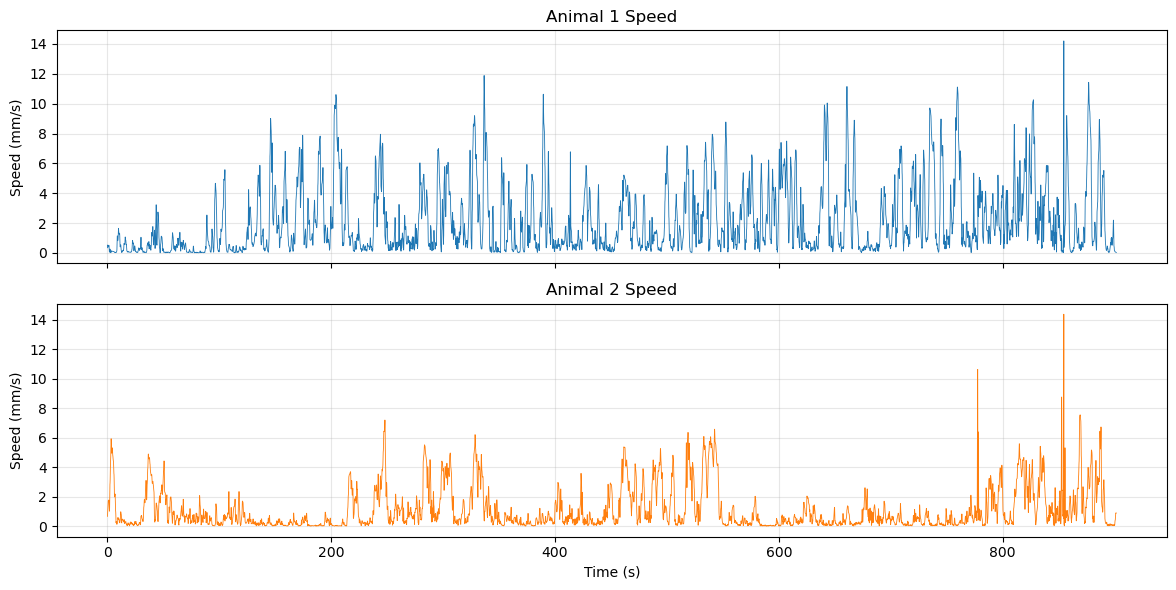

In [37]:
# Plot speed comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

t = merged.index / 1000  # Convert to seconds

ax1.plot(t, motion1['com1_speed'], lw=0.6, label='Animal 1')
ax1.set_ylabel('Speed (mm/s)')
ax1.set_title('Animal 1 Speed')
ax1.grid(alpha=0.3)

ax2.plot(t, motion2['com2_speed'], lw=0.6, label='Animal 2', color='C1')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Speed (mm/s)')
ax2.set_title('Animal 2 Speed')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()


---
## 4. Detect Approach Success Events

Identify approach→contact sequences where animals move toward each other and achieve contact.

The `find_approach_success()` function detects continuous segments where:
- Distance is decreasing (closing phase)
- Contact is achieved (distance drops below threshold)
- Minimum duration requirements are met


In [38]:
# Create frames DataFrame with required columns
frames = pd.DataFrame({
    'dist_mm': merged['dist_mm'],
    'dD_dt': merged['dD_dt']
}, index=merged.index)

# Detect approach success events
mask, events = find_approach_success(
    frames,
    contact_mm=50.0,      # "touch" threshold
    dD_dt_thresh=0.0,     # distance not increasing
    min_len=10,           # min frames from start to contact
    min_drop_mm=10.0      # require at least 10mm drop
)

print("Approach Success Detection Summary")
print("="*50)
print(f"Total approach success events: {len(events)}")
print(f"Total frames with approach behavior: {mask.sum()}")
print(f"\nFirst 5 events:")
for i, evt in enumerate(events[:5], 1):
    print(f"  Event {i}: frames {evt['start_idx']}-{evt['contact_idx']}, "
          f"drop {evt['drop_mm']:.1f}mm over {evt['duration_frames']} frames")


Approach Success Detection Summary
Total approach success events: 14
Total frames with approach behavior: 472

First 5 events:
  Event 1: frames 2656-2693, drop 36.8mm over 38 frames
  Event 2: frames 2840-2862, drop 47.0mm over 23 frames
  Event 3: frames 3155-3173, drop 28.9mm over 19 frames
  Event 4: frames 3923-3942, drop 16.9mm over 20 frames
  Event 5: frames 4039-4068, drop 18.8mm over 30 frames


---
## 5. Visualize Events in 3D

Display detected events as 3D skeletal poses in a grid layout.


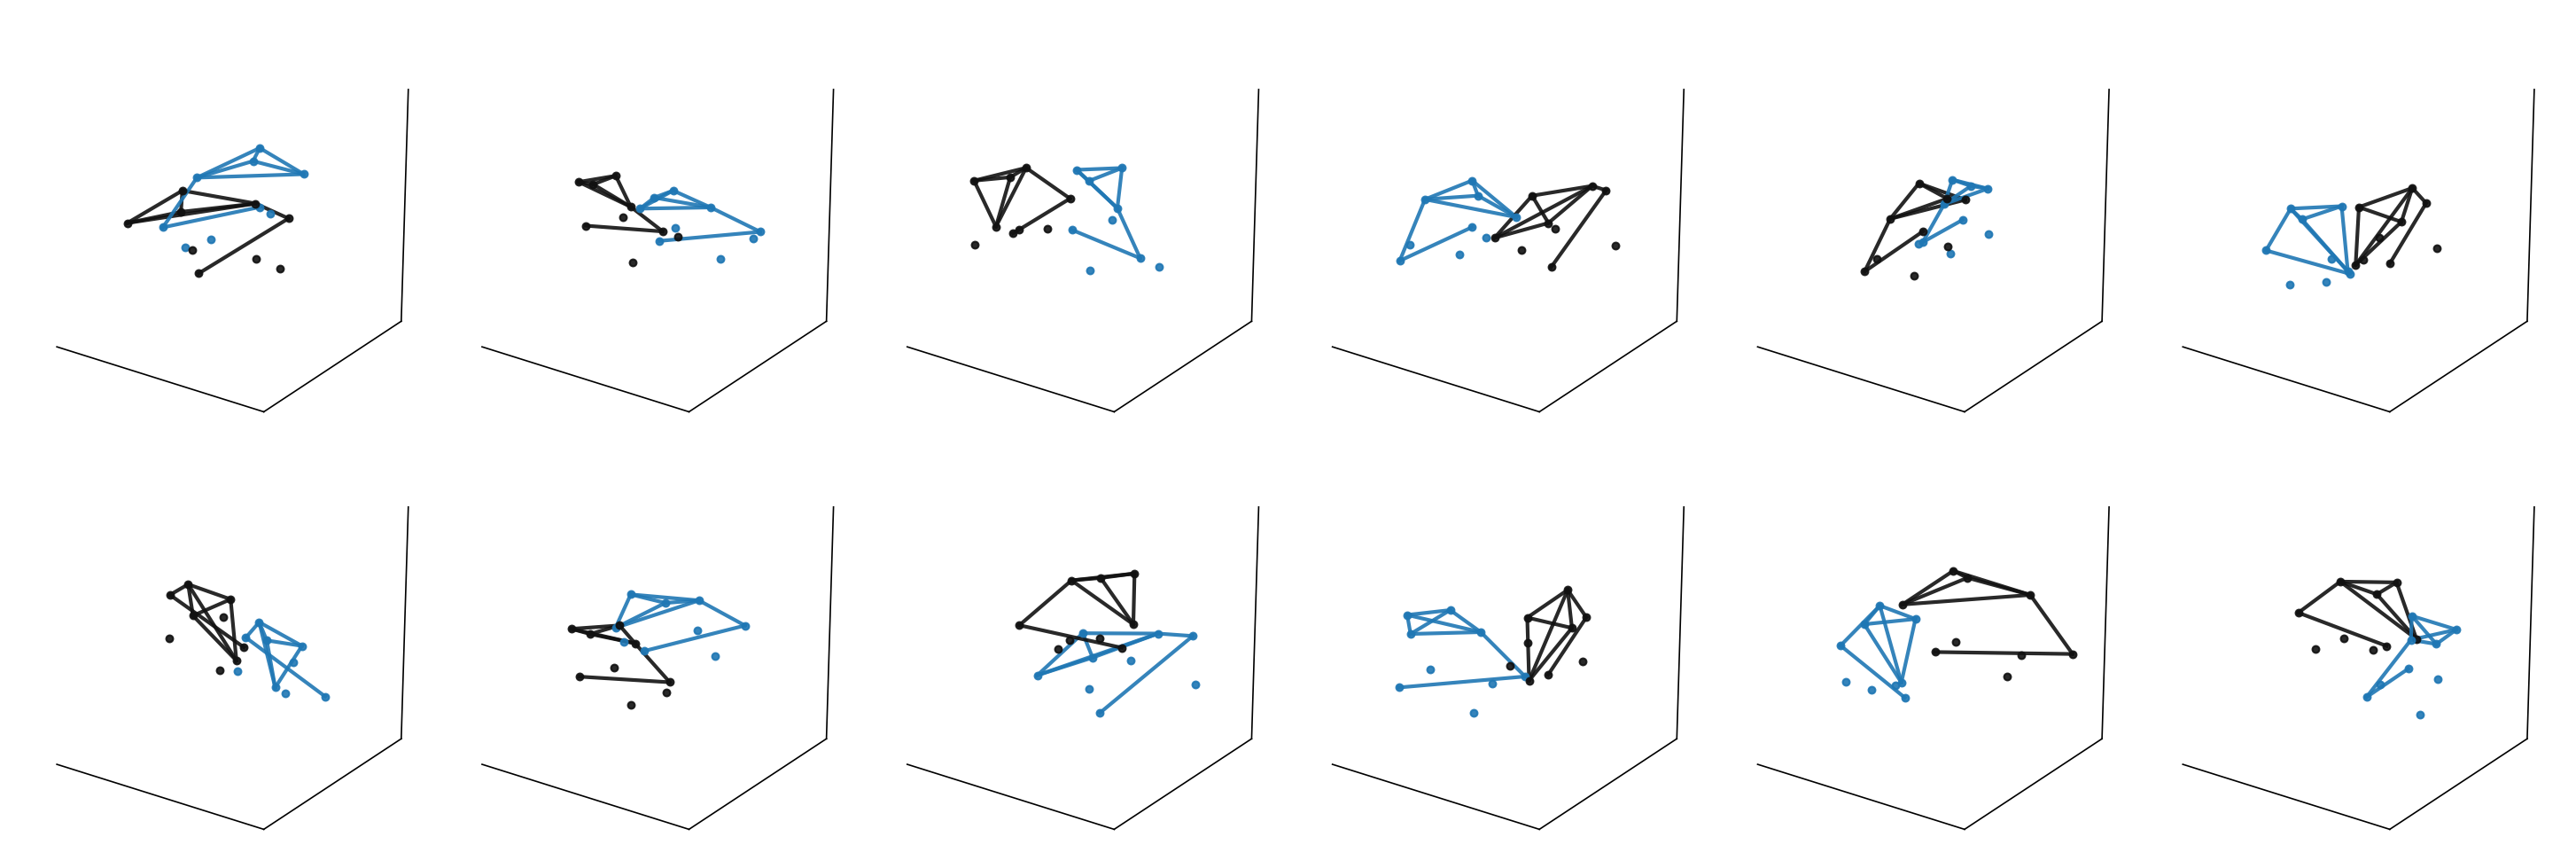

In [39]:
# 1. Create frames DataFrame with required columns
frames = pd.DataFrame({
    'dist_mm': merged['dist_mm'],
    'dD_dt': merged['dD_dt']
}, index=merged.index)

# 2. Detect events
mask, events = find_approach_success(
    frames,
    contact_mm=50.0,
    dD_dt_thresh=0.0,
    min_len=10,
    min_drop_mm=10.0
)

# 3. Map frame indices to timestamps  
event_frame_indices = [evt['contact_idx'] for evt in events[:12]]
event_timestamps = frames.index[event_frame_indices].tolist()

# 4. Import connectivity
from utlis import connectivity
COLOR = connectivity.COLOR_DICT["mouse20"]
CONNECTIVITY = connectivity.CONNECTIVITY_DICT["mouse20"]

# 5. Plot
plot_incidents_3d_grid(
    merged,
    event_timestamps,
    COLOR,
    CONNECTIVITY,
    animal1="a1",
    animal2="a2",
    ncols=6,
    zoom_mode="local",
    a1_color="#111111",
    a2_color="#1f77b4",
    dpi=150
)

---
## 6. Neural Activity & Distance Overview

Create a combined visualization of clustered neural activity and inter-animal distance.


/home/lq53/mir_repos/BBOP/utlis/present_vis/keypoint_3d_analysis.py:1795: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


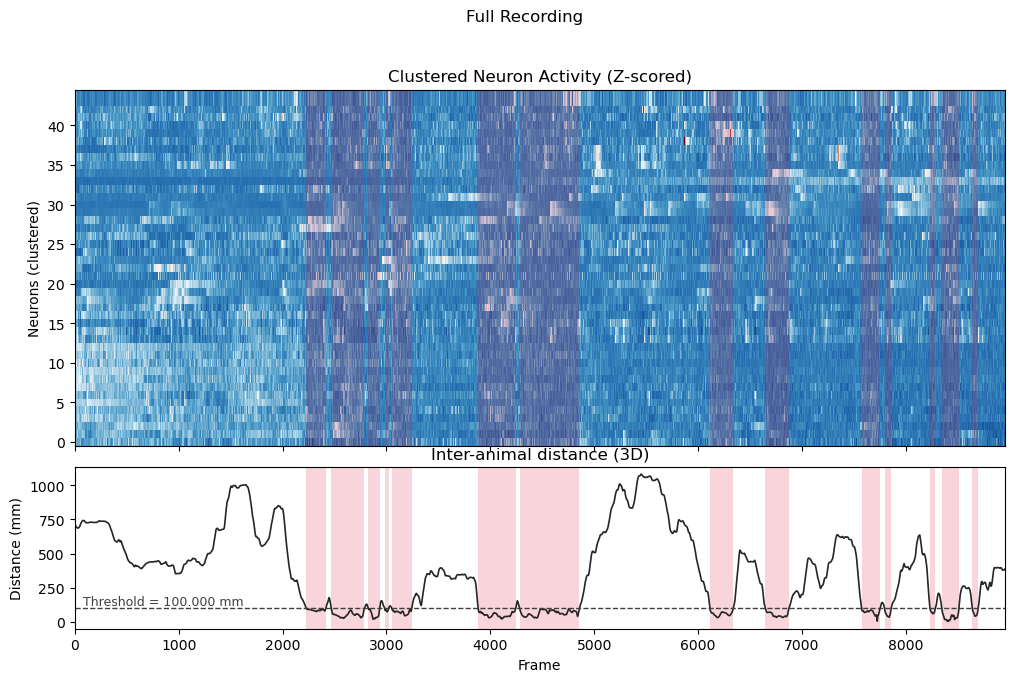

In [40]:
# Plot neural activity heatmap with distance
plot_ca_heatmap_and_distance(
    merged,
    variance_drop_pct=5.0,
    downsample_heatmap=2,
    cmap="RdBu_r",
    distance_smooth_window=1,
    title_prefix="Full Recording",
    save=False
)


---
## 7. Comprehensive Per-Event Analysis

Generate detailed multi-panel visualizations for each detected event.

This creates 4 figure types per event:
1. **Main Stack (5 panels):** Neural activity, COM distance, vertical separations
2. **Egocentric Maps:** Bearing × Elevation heatmaps
3. **Head Pitch:** Pitch angles over time
4. **Head Yaw:** Yaw angles over time


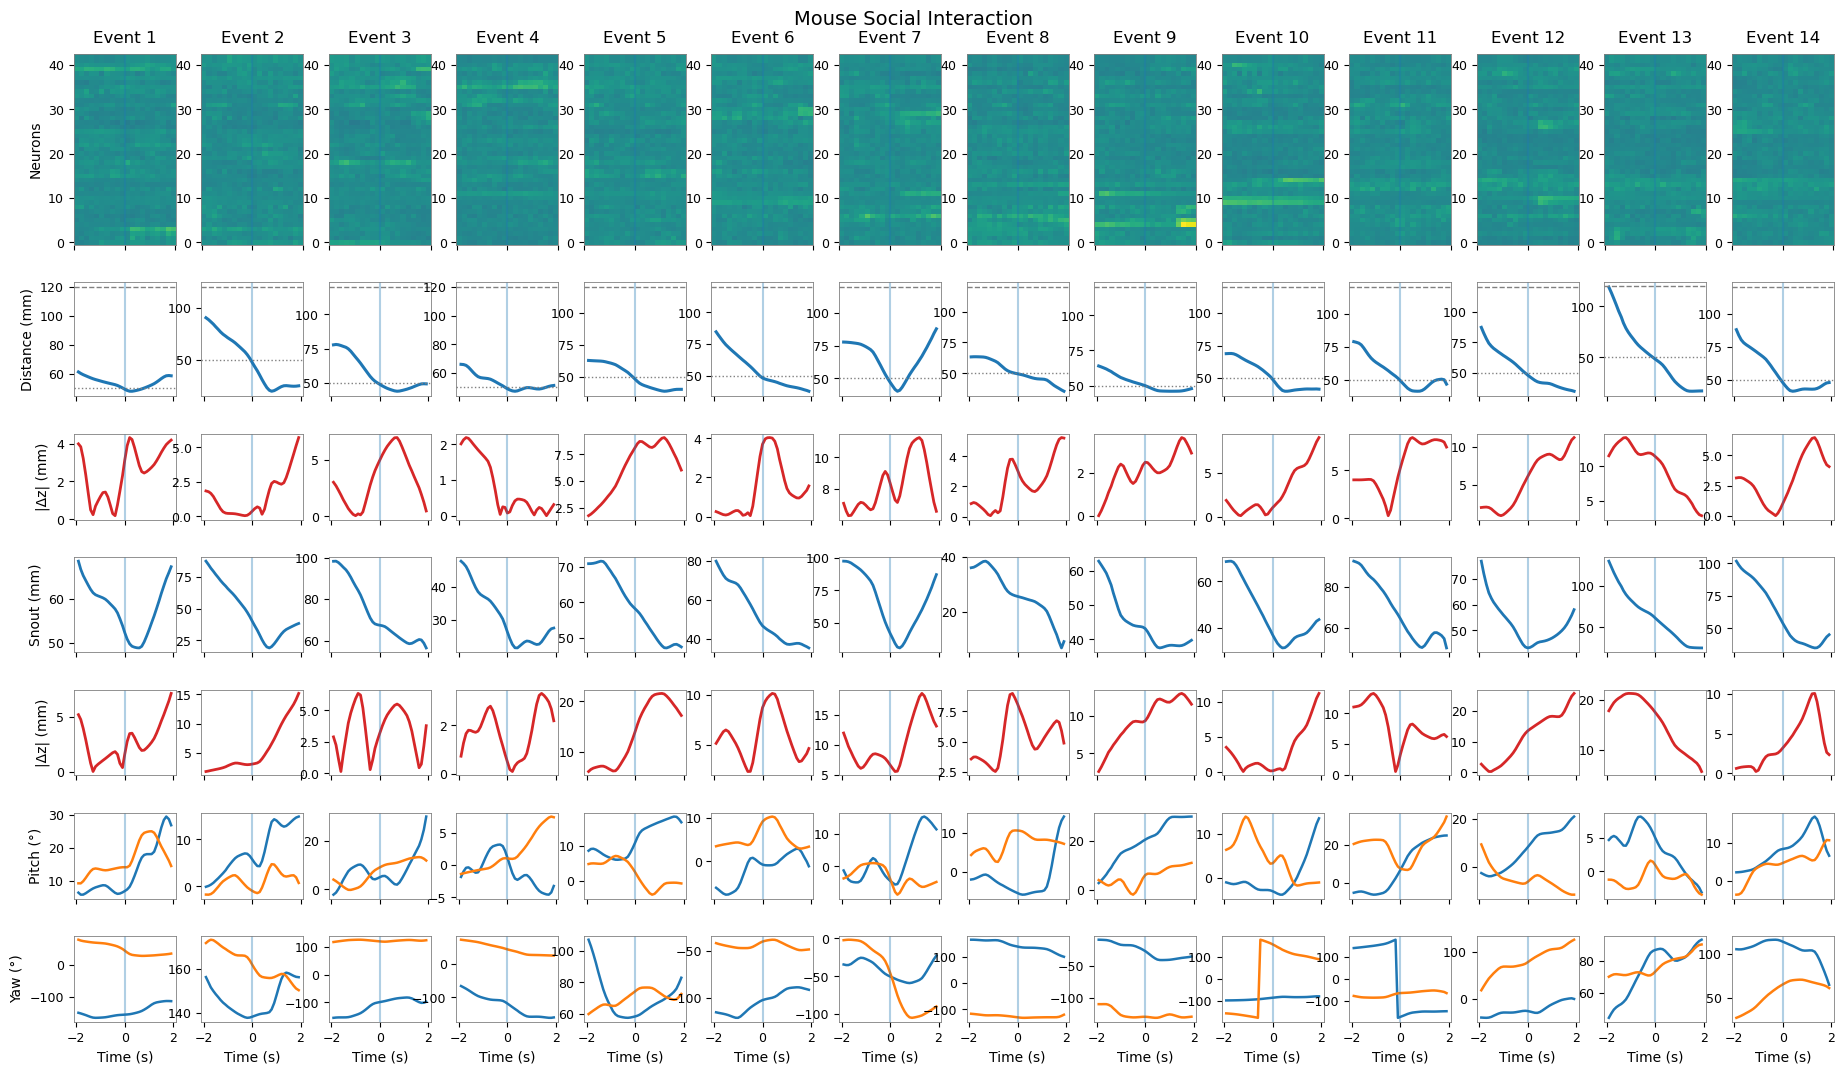

In [41]:
# # Analyze first few events in detail
# plot_incident_windows_newset(
#     merged,
#     frames,
#     mask,
#     pre_s=2.0,
#     post_s=2.0,
#     variance_drop_pct=10,
#     heatmap_downsample=2,
#     title_prefix="Mouse Social Interaction",
#     save=False,
#     out_dir="event_analysis"
# )


# Analyze first few events in detail
from utlis.present_vis.keypoint_3d_analysis import plot_incident_windows_newset_comb #a combed version for myself lol...

plot_incident_windows_newset_comb(
    merged,
    frames,
    mask,
    pre_s=2.0,
    post_s=2.0,
    variance_drop_pct=10,
    heatmap_downsample=2,
    # heatmap_cmap="RdBu_r",
    # event_indices=[1, 2, 3],
    title_prefix="Mouse Social Interaction",
    save=False,
    show_colorbar = False,
    legend_outside = True,
    out_dir="event_analysis"
)


---
## 8. Summary Statistics

Compile key metrics from the analysis.


In [42]:
# Compile summary statistics
summary = {
    'Total Frames': len(merged),
    'Recording Duration (s)': (merged.index[-1] - merged.index[0]) / 1000,
    'Approach Success Events': len(events),
    'Frames in Events': mask.sum(),
    'Mean Event Duration (frames)': np.mean([e['duration_frames'] for e in events]),
    'Mean Distance Drop (mm)': np.mean([e['drop_mm'] for e in events]),
    'Mean Inter-Animal Distance (mm)': merged['dist_mm'].mean(),
    'Min Distance Achieved (mm)': merged['dist_mm'].min(),
}

print("\nAnalysis Summary")
print("="*50)
for key, val in summary.items():
    if isinstance(val, float):
        print(f"{key}: {val:.2f}")
    else:
        print(f"{key}: {val}")



Analysis Summary
Total Frames: 8954
Recording Duration (s): 901.63
Approach Success Events: 14
Frames in Events: 472
Mean Event Duration (frames): 33.71
Mean Distance Drop (mm): 59.63
Mean Inter-Animal Distance (mm): 363.52
Min Distance Achieved (mm): 2.30


---

## Next Steps

- Adjust detection thresholds based on your data
- Export events for further analysis
- Generate publication-quality figures with `save=True`
- Use `visualize_frames_allcams()` for multi-camera validation

For more details on each function, see the module docstrings in `keypoint_3d_analysis.py`.
